# Environment

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MECP2')

# Load Data

## Fold Change

In [3]:
DEA_NEU = pd.read_csv("./DATA/DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("./DATA/DEA_NSC.csv", header=0)

In [ ]:
DEA_NEU.head()

In [ ]:
DEA_NEU.shape

In [6]:
DEA_NEU = DEA_NEU[DEA_NEU['padj'] < 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['padj'] < 0.05]

In [ ]:
print(DEA_NEU.shape)
print(DEA_NSC.shape)

In [ ]:
DEA_NEU.head()

## MECP2

In [9]:
mecp2_NEU = pd.read_csv("./DATA/allgenes_NEU.csv", header=0)
mecp2_NSC = pd.read_csv("./DATA/allgenes_NSC.csv", header=0)

In [ ]:
print(mecp2_NEU.shape)
print(mecp2_NSC.shape)

In [ ]:
mecp2_NEU.head()

# Histone Marks

In [12]:
histone_marks = pd.read_csv("./DATA/histone_marks.csv", header=0)


In [ ]:
histone_marks.head()

In [14]:
histone_marks_neu = histone_marks['NEU']
histone_marks_npc = histone_marks['NPC']


In [ ]:
histone_marks_neu.dropna(inplace=True)
histone_marks_npc.dropna(inplace=True)
print(histone_marks_neu.shape)
print(histone_marks_npc.shape)

In [16]:
histone_marks_neu = list(histone_marks_neu)
histone_marks_npc = list(histone_marks_npc)

# Plots

In [17]:
def volcano_plot(df1, df2, histone_marks=None, p_value_threshold=0.05, fc_threshold=1, labels=True, promoter_type='Exogenous_Promoter', size=10):
    # Calculate -log10(pvalue) for df1
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])

    # Create a color mapping based on df2
    color_mapping = {}
    alpha_mapping = {}
    size_mapping = {}
    
    # Set default color/alpha for genes not in df2
    for gene in df1['gene']:
        color_mapping[gene] = 'lightgrey'
        alpha_mapping[gene] = 0.3
        size_mapping[gene] = size  
    
    if histone_marks is not None:
        for gene in df1['gene']:
            if gene in histone_marks:
                color_mapping[gene] = 'yellow'
                alpha_mapping[gene] = 0.8
                size_mapping[gene] = 2*size

    # Override for genes found in df2
    for gene in df2['gene'].values:
        if gene in df1['gene'].values:
            if df2[df2['gene'] == gene][promoter_type].iloc[0]:
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] > 0:
                    color_mapping[gene] = 'green'
                    alpha_mapping[gene] = 0.8
                    size_mapping[gene] = 2*size  
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] < 0:
                    color_mapping[gene] = 'red'
                    alpha_mapping[gene] = 0.8
                    size_mapping[gene] = 2*size  

    # Create color list in the same order as df1
    colors = [color_mapping[gene] for gene in df1['gene']]
    alphas = np.array([alpha_mapping[gene] for gene in df1['gene']])
    sizes = np.array([size_mapping[gene] for gene in df1['gene']])
    plt.figure(figsize=(10, 8))

    # Plot background points first (lightgrey)
    background_mask = np.array([c == 'lightgrey' for c in colors])
    plt.scatter(df1.loc[background_mask, 'log2FoldChange'],
            df1.loc[background_mask, 'neg_log_pvalue'],
            c='lightgrey',
            alpha=alphas[background_mask],
            s=sizes[background_mask])

    # Plot yellow points (histone marks)
    yellow_mask = np.array([c == 'yellow' for c in colors])
    plt.scatter(df1.loc[yellow_mask, 'log2FoldChange'],
            df1.loc[yellow_mask, 'neg_log_pvalue'],
            c='yellow',
            alpha=alphas[yellow_mask],
            s=sizes[yellow_mask])

    # Plot colored points on top (red/green)
    colored_mask = np.array([c in ['red', 'green'] for c in colors])
    plt.scatter(df1.loc[colored_mask, 'log2FoldChange'],
            df1.loc[colored_mask, 'neg_log_pvalue'],
            c=[c for c, m in zip(colors, colored_mask) if m],
            alpha=alphas[colored_mask],
            s=sizes[colored_mask])

    # Add labels and title
    plt.xlabel('log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.title('Volcano Plot of Differential Expression', fontsize=14)

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                    markerfacecolor='red', label=f'\n\n{promoter_type} Enriched', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                    markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w',
                    markerfacecolor='yellow', label='Histone Marks', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', 
                    markerfacecolor='lightgrey', label='Not in df2', markersize=7)
    ]

    plt.legend(handles=legend_elements, loc='upper right')

    if labels:
        # Add gene labels for significant genes
        pvalue_threshold = -np.log10(p_value_threshold)
        fc_threshold = fc_threshold 

        for idx, row in df1.iterrows():
            if (abs(row['log2FoldChange']) > fc_threshold) and (row['neg_log_pvalue'] > pvalue_threshold):
                plt.annotate(row['gene'], 
                            (row['log2FoldChange'], row['neg_log_pvalue']),
                            xytext=(5, 5), 
                            textcoords='offset points',
                            fontsize=8)

    plt.tight_layout()

    plt.show()

In [ ]:
volcano_plot(DEA_NEU, mecp2_NEU, p_value_threshold=0.05, fc_threshold=1, labels=False, histone_marks=histone_marks_neu, size=10)

In [ ]:
volcano_plot(DEA_NSC, mecp2_NSC, p_value_threshold=0.05, fc_threshold=4, labels=False, histone_marks=histone_marks_npc, size=10)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import pandas as pd

def volcano_plot_data(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    p_value_threshold: float = 0.05,
    fc_threshold: float = 1,
    promoter_type: str = 'Exogenous_Promoter',
    size: int = 10
) -> Dict:
    # Validate input data
    required_columns_df1 = {'gene', 'padj', 'log2FoldChange'}
    required_columns_df2 = {'gene', promoter_type}
    
    if not required_columns_df1.issubset(df1.columns):
        raise ValueError(f"df1 missing required columns: {required_columns_df1 - set(df1.columns)}")
    if not required_columns_df2.issubset(df2.columns):
        raise ValueError(f"df2 missing required columns: {required_columns_df2 - set(df2.columns)}")
    
    # Handle NaN values
    df1 = df1.dropna(subset=['padj', 'log2FoldChange'])
    
    # Calculate -log10(pvalue)
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])
    
    # Initialize mappings
    color_mapping = {gene: 'grey' for gene in df1['gene']}
    alpha_mapping = {gene: 0.3 for gene in df1['gene']}
    size_mapping = {gene: size for gene in df1['gene']}
    
    # Update mappings for significant genes
    for gene in df2['gene'].values:
        if gene in df1['gene'].values:
            gene_df1 = df1[df1['gene'] == gene]
            if (gene_df1['padj'].iloc[0] < p_value_threshold and 
                abs(gene_df1['log2FoldChange'].iloc[0]) > fc_threshold and 
                df2[df2['gene'] == gene][promoter_type].iloc[0]):
                    color_mapping[gene] = 'blue'
                    alpha_mapping[gene] = 0.8
                    size_mapping[gene] = 2 * size
    
    # Create masks and separate data
    colors = [color_mapping[gene] for gene in df1['gene']]
    background_mask = np.array([c == 'grey' for c in colors])
    colored_mask = ~background_mask
    
    return {
        'background': {
            'x': df1.loc[background_mask, 'log2FoldChange'].values,
            'y': df1.loc[background_mask, 'neg_log_pvalue'].values,
            'alpha': [alpha_mapping[gene] for gene in df1.loc[background_mask, 'gene']],
            'size': [size_mapping[gene] for gene in df1.loc[background_mask, 'gene']]
        },
        'colored': {
            'x': df1.loc[colored_mask, 'log2FoldChange'].values,
            'y': df1.loc[colored_mask, 'neg_log_pvalue'].values,
            'colors': ['blue'] * colored_mask.sum(),
            'alpha': [alpha_mapping[gene] for gene in df1.loc[colored_mask, 'gene']],
            'size': [size_mapping[gene] for gene in df1.loc[colored_mask, 'gene']]
        },
        'fc_threshold': fc_threshold,
        'p_value_threshold': p_value_threshold
    }

def plot_volcanoes_side_by_side(
    data1: Dict,
    data2: Dict,
    titles: Tuple[str, str] = ('Plot 1', 'Plot 2'),
    promoter_type: str = 'Exogenous_Promoter',
    x_limits: Tuple[float, float] = (-5, 15),
    y_limits: Tuple[float, float] = (0, 320)
) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]]:
    """
    Create side-by-side volcano plots.
    
    Args:
        data1: First plot data from volcano_plot_data
        data2: Second plot data from volcano_plot_data
        titles: Tuple of titles for the two plots
        promoter_type: Label for the promoter type in legend
        x_limits: Tuple of (min, max) for x-axis
        y_limits: Tuple of (min, max) for y-axis
        
    Returns:
        Figure and axes objects
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    def plot_on_axis(ax: plt.Axes, data: Dict) -> None:
        ax.scatter(data['background']['x'], data['background']['y'],
                  c='grey', alpha=data['background']['alpha'],
                  s=data['background']['size'])
        ax.scatter(data['colored']['x'], data['colored']['y'],
                  c=data['colored']['colors'], alpha=data['colored']['alpha'],
                  s=data['colored']['size'])
        ax.axhline(y=-np.log10(data['p_value_threshold']), color='r', linestyle='--', alpha=0.5)
        ax.axvline(x=data['fc_threshold'], color='r', linestyle='--', alpha=0.5)
        ax.axvline(x=-data['fc_threshold'], color='r', linestyle='--', alpha=0.5)
    
    plot_on_axis(ax1, data1)
    plot_on_axis(ax2, data2)
    
    for ax, title in zip([ax1, ax2], titles):
        ax.set_xlabel('log2 Fold Change', fontsize=12)
        ax.set_ylabel('-log10(p-value)', fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(*x_limits)
        ax.set_ylim(*y_limits)
    
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='blue',
                  label=f'{promoter_type} Enriched\n(p < {data1["p_value_threshold"]}, |FC| > {data1["fc_threshold"]})',
                  markersize=10)
    ]
    
    fig.legend(handles=legend_elements, loc='center right')
    plt.tight_layout()
    
    return fig, (ax1, ax2)

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


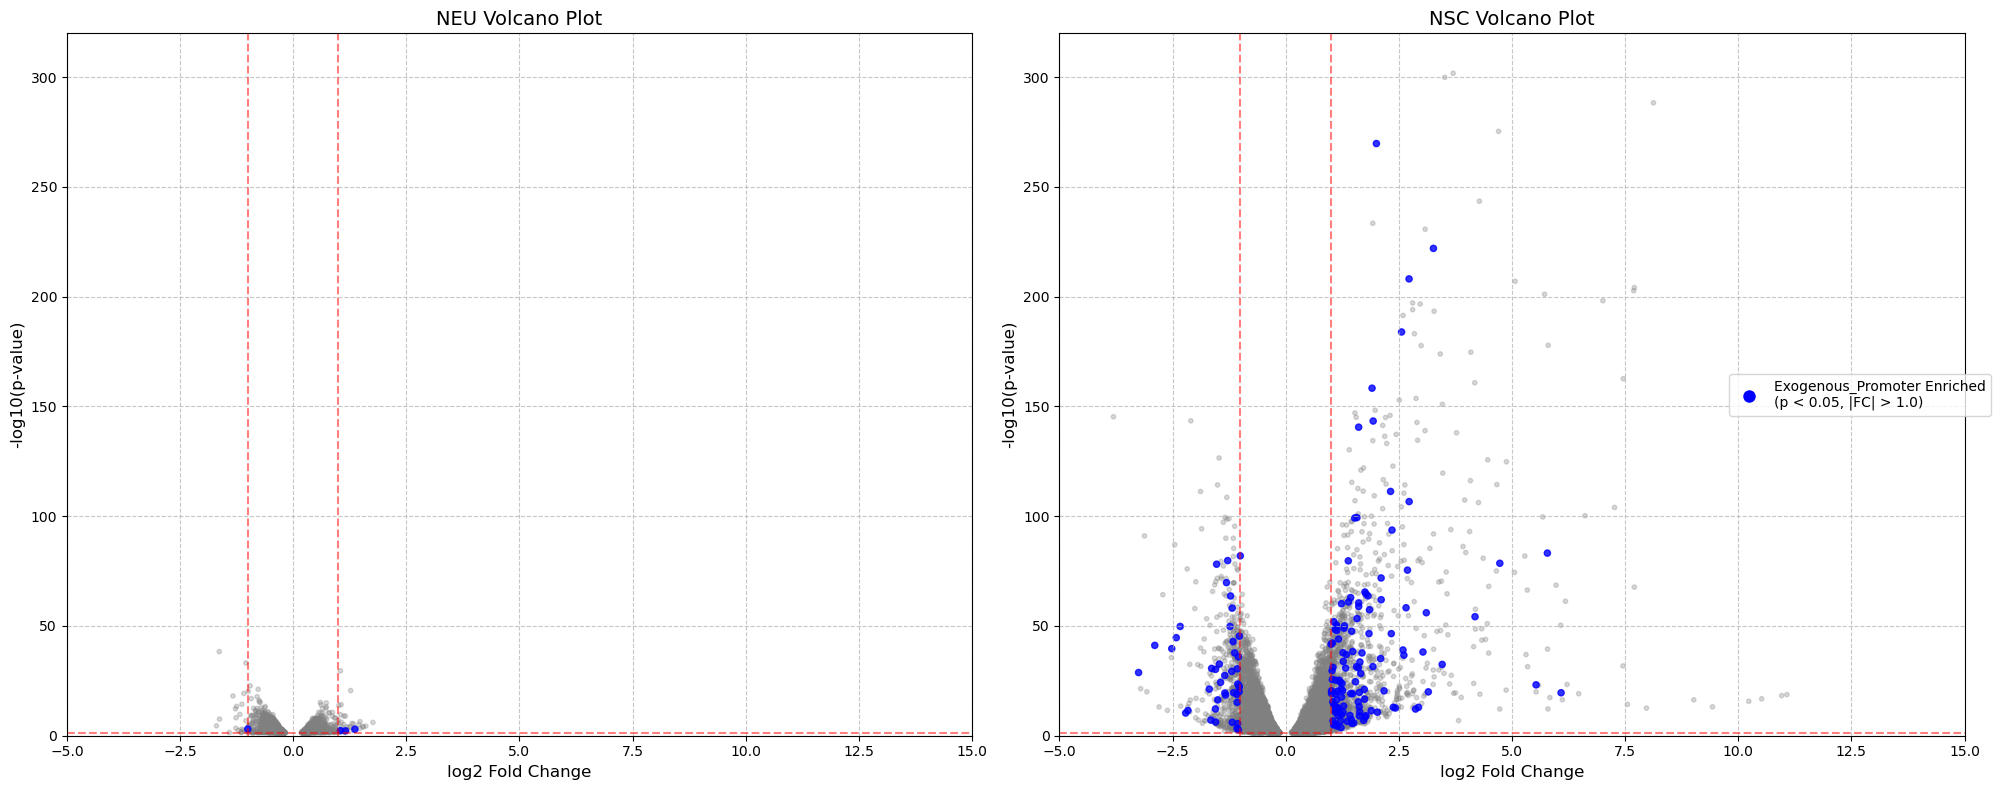

In [43]:
data1 = volcano_plot_data(DEA_NEU, mecp2_NEU, size=10, fc_threshold=1.0)
data2 = volcano_plot_data(DEA_NSC, mecp2_NSC, size=10, fc_threshold=1.0)

# Create the plots
fig, axes = plot_volcanoes_side_by_side(
    data1, data2,
    titles=('NEU Volcano Plot', 'NSC Volcano Plot')
)
plt.show()

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


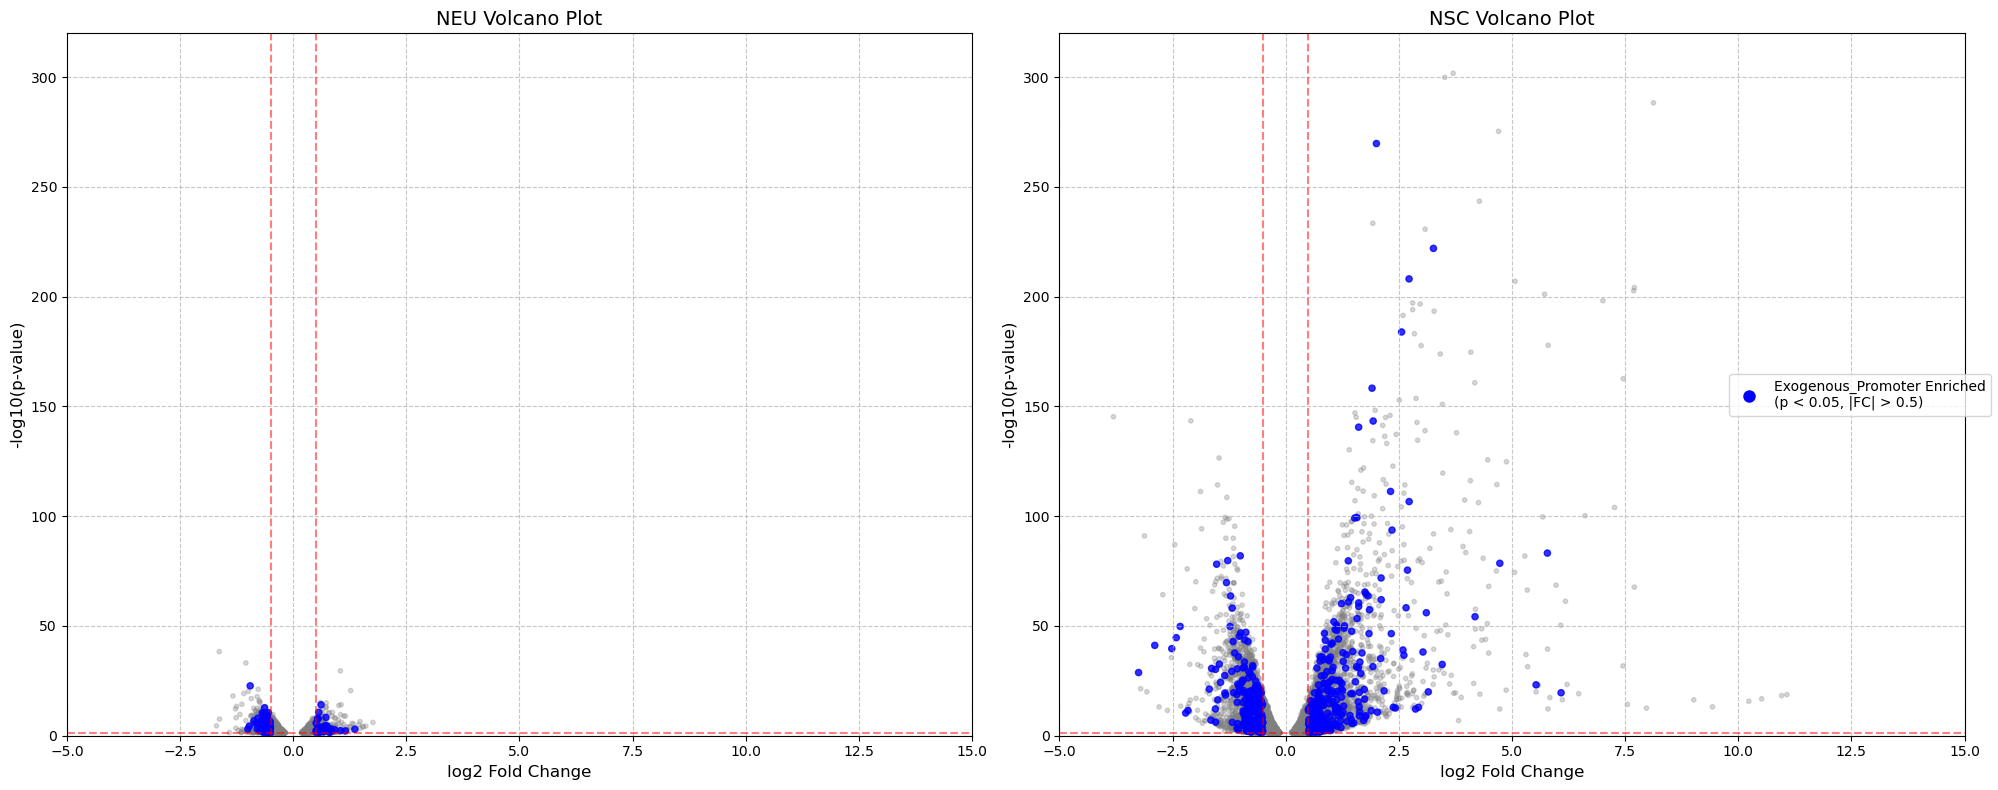

In [44]:
data1 = volcano_plot_data(DEA_NEU, mecp2_NEU, size=10, fc_threshold=0.5)
data2 = volcano_plot_data(DEA_NSC, mecp2_NSC, size=10, fc_threshold=0.5)

# Create the plots
fig, axes = plot_volcanoes_side_by_side(
    data1, data2,
    titles=('NEU Volcano Plot', 'NSC Volcano Plot')
)
plt.show()

In [46]:
def plot_single_volcano(data, title='Volcano Plot', 
                       promoter_type='Exogenous_Promoter',
                       fc_threshold=1.0, p_value_threshold=0.05):
    # Create single figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot background points
    ax.scatter(data['background']['x'], data['background']['y'], 
              c='grey', alpha=data['background']['alpha'],
              s=data['background']['size'])
    
    # Plot colored points
    ax.scatter(data['colored']['x'], data['colored']['y'],
              c=data['colored']['colors'], alpha=data['colored']['alpha'],
              s=data['colored']['size'])
    
    # Add lines for thresholds
    ax.axhline(y=-np.log10(p_value_threshold), color='r', linestyle='--', alpha=0.5)
    ax.axvline(x=fc_threshold, color='r', linestyle='--', alpha=0.5)
    ax.axvline(x=-fc_threshold, color='r', linestyle='--', alpha=0.5)
    
    # Configure axes
    ax.set_xlabel('log2 Fold Change', fontsize=12)
    ax.set_ylabel('-log10(p-value)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Calculate axis limits based on data with some padding
    x_data = data['background']['x'].tolist() + data['colored']['x'].tolist()
    y_data = data['background']['y'].tolist() + data['colored']['y'].tolist()
    
    # Filter out inf and nan values
    x_data = [x for x in x_data if np.isfinite(x)]
    y_data = [y for y in y_data if np.isfinite(y)]
    
    x_min, x_max = min(x_data), max(x_data)
    y_min, y_max = min(y_data), max(y_data)
    
    # Add 5% padding
    x_padding = (x_max - x_min) * 0.05
    y_padding = (y_max - y_min) * 0.05
    
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='blue', 
                  label=f'{promoter_type} Enriched\n(p < {p_value_threshold}, |FC| > {fc_threshold})', 
                  markersize=10)
    ]
    
    ax.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    
    return fig, ax

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


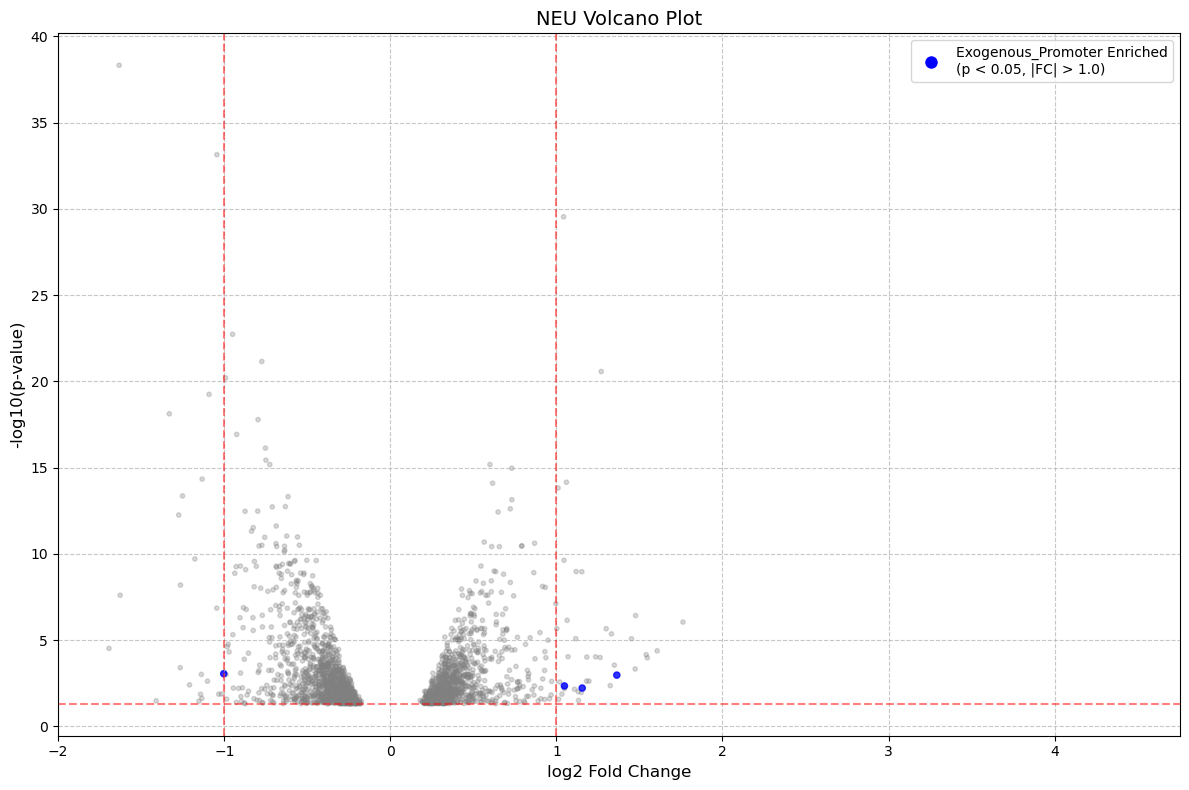

In [50]:
data = volcano_plot_data(DEA_NEU, mecp2_NEU, size=10, fc_threshold=1.0)

# Create the single plot
fig, ax = plot_single_volcano(data, title='NEU Volcano Plot', fc_threshold=1.0)
plt.show()

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


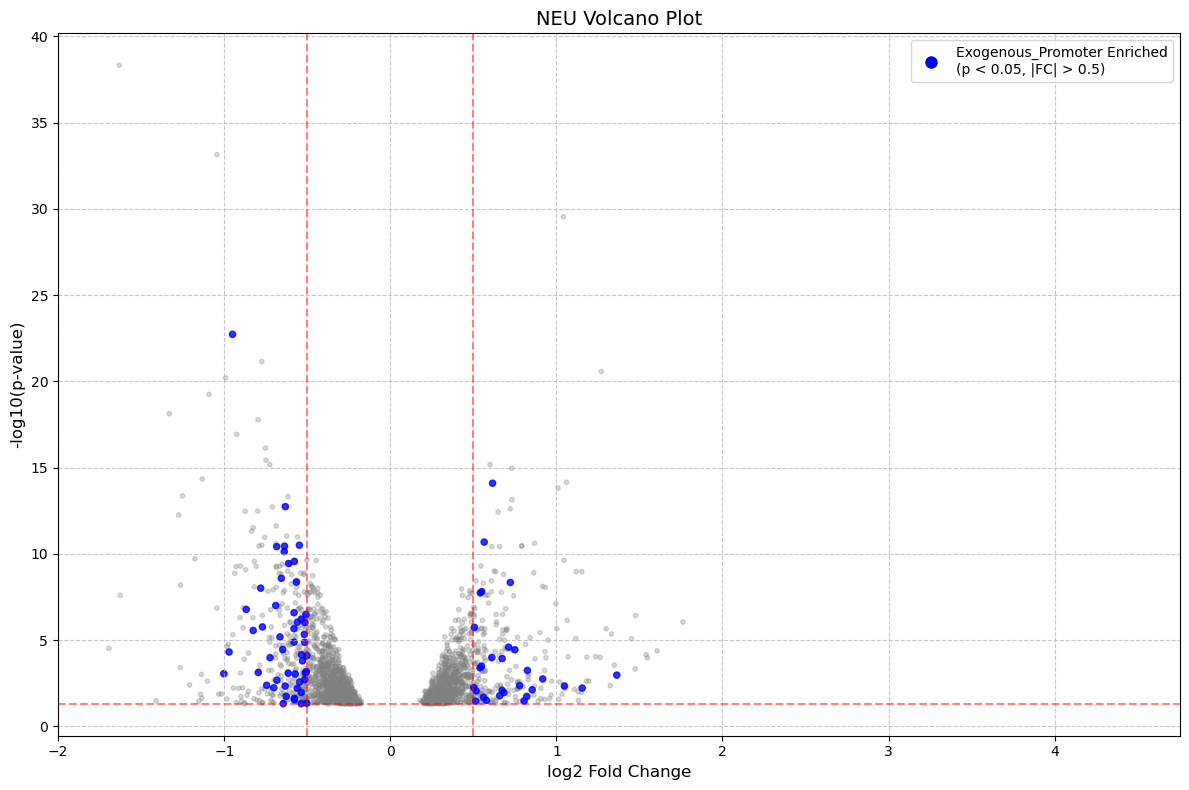

In [51]:
data = volcano_plot_data(DEA_NEU, mecp2_NEU, size=10, fc_threshold=0.5)

# Create the single plot
fig, ax = plot_single_volcano(data, title='NEU Volcano Plot', fc_threshold=0.5)
plt.show()

# Legacy code

In [20]:
def volcano_plot_data(df1, df2, histone_marks=None, p_value_threshold=0.05, fc_threshold=1, promoter_type='Exogenous_Promoter', size=10):
    # Calculate -log10(pvalue) for df1
    df1['neg_log_pvalue'] = -np.log10(df1['padj'])

    # Create a color mapping based on df2
    color_mapping = {}
    alpha_mapping = {}
    size_mapping = {}
    
    # Set default color/alpha for genes not in df2
    for gene in df1['gene']:
        color_mapping[gene] = 'grey'
        alpha_mapping[gene] = 0.3
        size_mapping[gene] = size 

    # if histone_marks is not None:
    #     for gene in df1['gene']:
    #         if gene in histone_marks:
    #             color_mapping[gene] = 'yellow'
    #             alpha_mapping[gene] = 0.8
    #             size_mapping[gene] = 2*size 

    # Override for genes found in df2
    for gene in df2['gene'].values:
        if gene in df1['gene'].values:
            if df2[df2['gene'] == gene][promoter_type].iloc[0]:
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] > 0:
                    color_mapping[gene] = 'blue'
                    alpha_mapping[gene] = 0.8
                    size_mapping[gene] = 2*size  
                if df2[df2['gene'] == gene]['log2FoldChange'].iloc[0] < 0:
                    color_mapping[gene] = 'blue'
                    alpha_mapping[gene] = 0.8
                    size_mapping[gene] = 2*size  

    # Create color list in the same order as df1
    colors = [color_mapping[gene] for gene in df1['gene']]
    alphas = [alpha_mapping[gene] for gene in df1['gene']]
    sizes = [size_mapping[gene] for gene in df1['gene']]

    # Create masks for different point types
    background_mask = [c == 'grey' for c in colors]
    # yellow_mask = [c == 'yellow' for c in colors]
    colored_mask = [c in ['blue'] for c in colors]

    # Prepare data structures for each point type
    background_data = {
        'x': df1.loc[background_mask, 'log2FoldChange'].values,
        'y': df1.loc[background_mask, 'neg_log_pvalue'].values,
        'alpha': [a for a, m in zip(alphas, background_mask) if m],
        'size': [s for s, m in zip(sizes, background_mask) if m]
    }
    
    # yellow_data = {
    #     'x': df1.loc[yellow_mask, 'log2FoldChange'].values,
    #     'y': df1.loc[yellow_mask, 'neg_log_pvalue'].values,
    #     'alpha': [a for a, m in zip(alphas, yellow_mask) if m],
    #     'size': [s for s, m in zip(sizes, yellow_mask) if m]
    # }
    
    colored_data = {
        'x': df1.loc[colored_mask, 'log2FoldChange'].values,
        'y': df1.loc[colored_mask, 'neg_log_pvalue'].values,
        'colors': [c for c, m in zip(colors, colored_mask) if m],
        'alpha': [a for a, m in zip(alphas, colored_mask) if m],
        'size': [s for s, m in zip(sizes, colored_mask) if m]
    }

    # Prepare label data for significant genes
    label_data = None
    if abs(fc_threshold) > 0:
        pvalue_threshold = -np.log10(p_value_threshold)
        significant_mask = (abs(df1['log2FoldChange']) > fc_threshold) & (df1['neg_log_pvalue'] > pvalue_threshold)
        label_data = {
            'x': df1.loc[significant_mask, 'log2FoldChange'].values,
            'y': df1.loc[significant_mask, 'neg_log_pvalue'].values,
            'labels': df1.loc[significant_mask, 'gene'].values
        }

    return {
        'background': background_data,
        # 'histone': yellow_data,
        'colored': colored_data,
        'labels': label_data
    }

def plot_volcanoes_side_by_side(data1, data2, titles=('Plot 1', 'Plot 2'), 
                               promoter_type='Exogenous_Promoter', 
                               x_limits=(-5, 15), y_limits=(0, 320)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Helper function to plot on a given axis
    def plot_on_axis(ax, data):
        # Plot background points
        ax.scatter(data['background']['x'], data['background']['y'], 
                  c='grey', alpha=data['background']['alpha'],
                  s=data['background']['size'])
        
        # Plot histone marks if present
        # if len(data['histone']['x']) > 0:
        #     ax.scatter(data['histone']['x'], data['histone']['y'],
        #               c='yellow', alpha=data['histone']['alpha'],
        #               s=data['histone']['size'])
        
        # Plot colored points
        ax.scatter(data['colored']['x'], data['colored']['y'],
                  c=data['colored']['colors'], alpha=data['colored']['alpha'],
                  s=data['colored']['size'])
        
        # Add lines for thresholds
        ax.axhline(y=-np.log10(0.05), color='r', linestyle='--', alpha=0.5)
        ax.axvline(x=1, color='r', linestyle='--', alpha=0.5)
        ax.axvline(x=-1, color='r', linestyle='--', alpha=0.5)
        
        # Add labels if present
        if data['labels'] is not None:
            for x, y, label in zip(data['labels']['x'], data['labels']['y'], 
                                 data['labels']['labels']):
                ax.annotate(label, (x, y), xytext=(5, 5), 
                           textcoords='offset points', fontsize=8)
    
    # Plot both datasets
    plot_on_axis(ax1, data1)
    plot_on_axis(ax2, data2)
    
    # Configure axes
    for ax, title in zip([ax1, ax2], titles):
        ax.set_xlabel('log2 Fold Change', fontsize=12)
        ax.set_ylabel('-log10(p-value)', fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlim(*x_limits)
        ax.set_ylim(*y_limits)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='blue', label=f'\n\n{promoter_type} Enriched', markersize=10),
        # plt.Line2D([0], [0], marker='o', color='w', 
        #           markerfacecolor='green', markersize=10),
        # plt.Line2D([0], [0], marker='o', color='w',
        #           markerfacecolor='yellow', label='Histone Marks', markersize=10),
        # plt.Line2D([0], [0], marker='o', color='w', 
        #           markerfacecolor='lightgrey', label='Not in df2', markersize=7)
    ]
    
    fig.legend(handles=legend_elements, loc='center right')
    plt.tight_layout()
    
    return fig, (ax1, ax2)

In [ ]:
# Get the data
data1 = volcano_plot_data(DEA_NEU, mecp2_NEU, histone_marks=histone_marks_neu, size=10)
data2 = volcano_plot_data(DEA_NSC, mecp2_NSC, histone_marks=histone_marks_npc, size=10)

# Create the plots
fig, axes = plot_volcanoes_side_by_side(data1, data2, 
                                       titles=('NEU Volcano Plot', 'NSC Volcano Plot'))
plt.show()